# TRUSTWORTHY AI: Transparency Requirement

#### Script to ensure the Transparency requirement for a dataset. Based on EU guidelines.
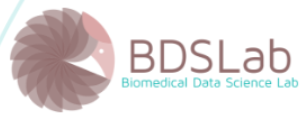


## TABLE OF CONTENTS:

<div class="alert" style="margin-top: 20px">

1. [Data preparation](#data-preparation)<br>
1.1. [Data pre-processing](#data-pre-processing)<br>

2. [Model Development](#model-development)<br>
2.1. [Design](#design)<br>
2.2. [Training and Evaluation](#training-evaluation)<br>
3. [Deployment and Use](#deployment-use)<br>
4. [Management](#management)<br>
4.1. [Documentation](#documentation)<br>
4.3. [Cooperation and Incident Sharing](#cooperation-and-sharing)<br>
</div>


The key requirement of transparency covers three main concepts:

* **Traceability:** documenting processes to identify the reasons why a decision was wrong and to prevent future failuress.
*  **Explainability:** explain both the AI's technical processes and the associated human decision the AI decision must to be understable by a human.
*  **Communication:** convey the capabilities and limitations to the end users.

We start by preparing the working environment. Import all the necessary libraries.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import plotly.subplots as sp

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize, LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report

import shap
import seaborn as sns
from datetime import datetime
import prince
import math
import json

from functions.NaiveBayesMixed import NaiveBayesMixed
from functions.handleData import handleData

Load the dataset and define Metadata

In [14]:
path = 'C:\\Users\\carlo\\OneDrive - UPV\\ESCRITORIO CARLOS\\UPV\\BECA COLABORACIÓN\\Datasets\\Diabetes\\' 
file_name = 'dataset_train_QC.csv'
data = pd.read_csv(path + file_name)

# Create a subset to work more efficiently
data = data.sample(frac = 0.5, random_state=100) 

In [15]:
# Load metadata from the JSON file
file_name = 'metadata_QC.json'
with open(path + file_name, 'r') as json_file:
    metadata = json.load(json_file)

# Assign variables from loaded metadata
dataset = data
output = metadata["output"]
positive_class = metadata["positive_class"]

In [16]:
### Uncomment only if you want to binarise a multi-class classification problem ###
if positive_class:
    dataset[output] = pd.Series(np.where(dataset[output] == positive_class, 1, 0), index=dataset[output].index, name=output)

features_df = dataset.drop(output,axis=1)
tags_df = dataset[output] 

unique_classes = np.unique(tags_df)
n_classes = len(unique_classes)
feat_num = [key for key, value in metadata["feat_types"].items() if value == "numerical"]
feat_cat = [key for key, value in metadata["feat_types"].items() if value == "categorical"]
feature_names = features_df.columns

handleData = handleData(feat_num, feat_cat)

## 1. DATA PREPARATION <a class="anchor" id="data-preparation"></a>

### 1.1. Data Pre-processing: <a class="anchor" id="pre-processing"></a>
To ensure the principle of transparency, it is important to study the data provenance as it is collected (`Data provenance`). Registering data lineage increases transparecny and reproducibility while mitigating any poisoned data.

We look to see if the inicial metadata comntains any information about the provenance of the data.

In [5]:
if metadata["data_provenance"]:
    print("The following data provenance information has been provided to increase the transparency of your model:")
    print(metadata["data_provenance"][0])
    print("The variable that indicates the provenance of each instance is Admission.", metadata["data_provenance"][1])

else:
    print("Data provenance is empty.")

The following data provenance information has been provided to increase the transparency of your model:
A Health Facts database that represents 10 years (1999-2008) of clinical care at 130 hospitals in United States.
The variable that indicates the provenance of each instance is Admission. admission_type


It might be interesting to add a descriptive plot to the data pre-processing stage to analyse the intrinsic relationships between the features (`General exploratory analysis`). It is a little complicated to compare numerical and categorical features, but a correct way to do this for numerical features might be to use a correlation matrix. We offer to visualise this in the form of a 'heat map' or 'pair plot':

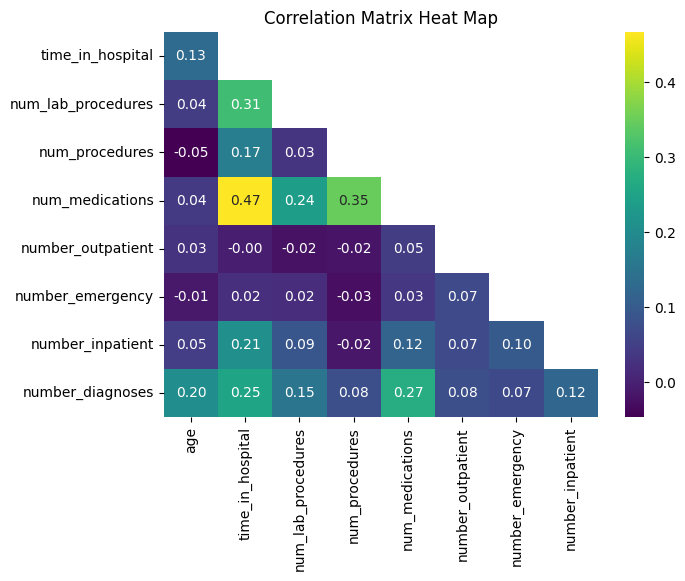

In [6]:
# Calculate numerical correlation matrix
corr_num = dataset[feat_num].corr()
mask = np.triu(np.ones_like(corr_num, dtype=bool)) # A mask to hide the upper right part of the matrix (it is duplicated)
#
plt.figure(figsize=(7, 5))
sns.heatmap(corr_num.iloc[1:, :-1], mask=mask[1:, :-1], annot=True, fmt=".2f", cmap=sns.color_palette("viridis", as_cmap=True))
plt.title('Correlation Matrix Heat Map')
plt.xticks(rotation=90)
plt.show()

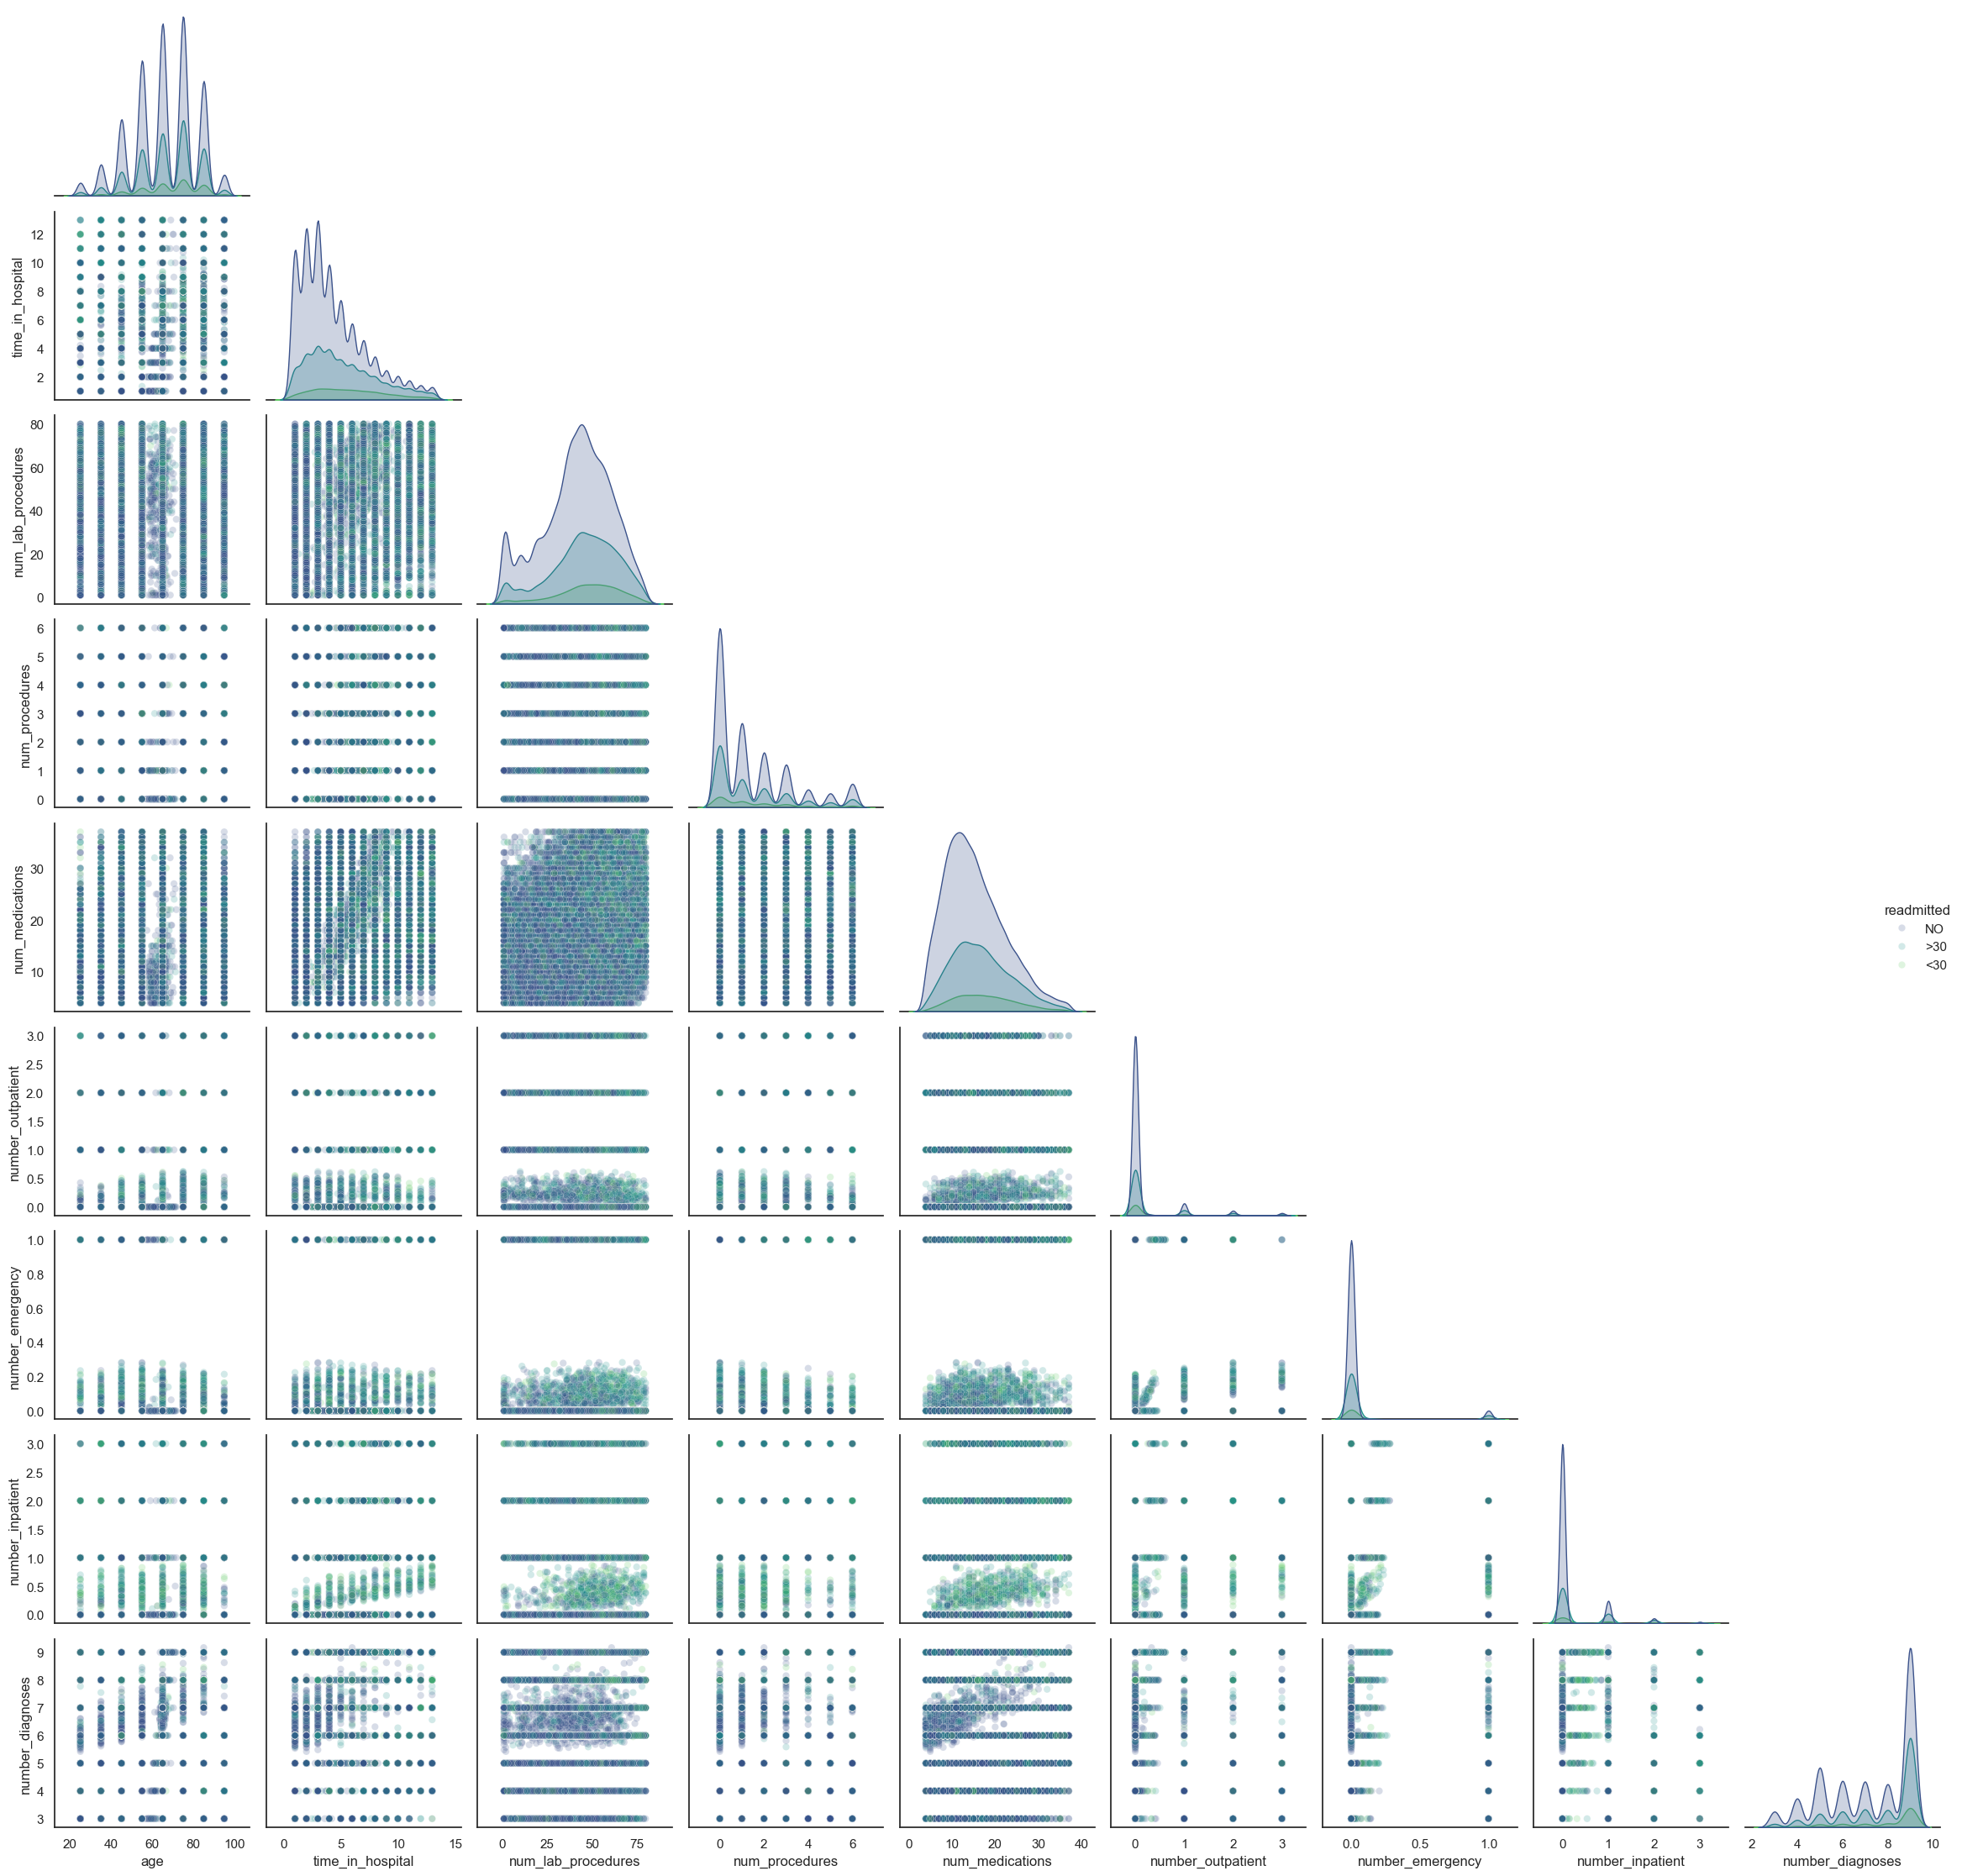

In [7]:
sns.set(style="white")

sns.pairplot(dataset[feat_num + [output]], kind="scatter", plot_kws={"alpha": 0.2}, diag_kind='kde', corner=True, hue=output, palette='viridis')
plt.tight_layout()
plt.show()

Similarly, in order to identify possible correlations between categorical features and tags, it might be useful to display a bar chart such as the following:

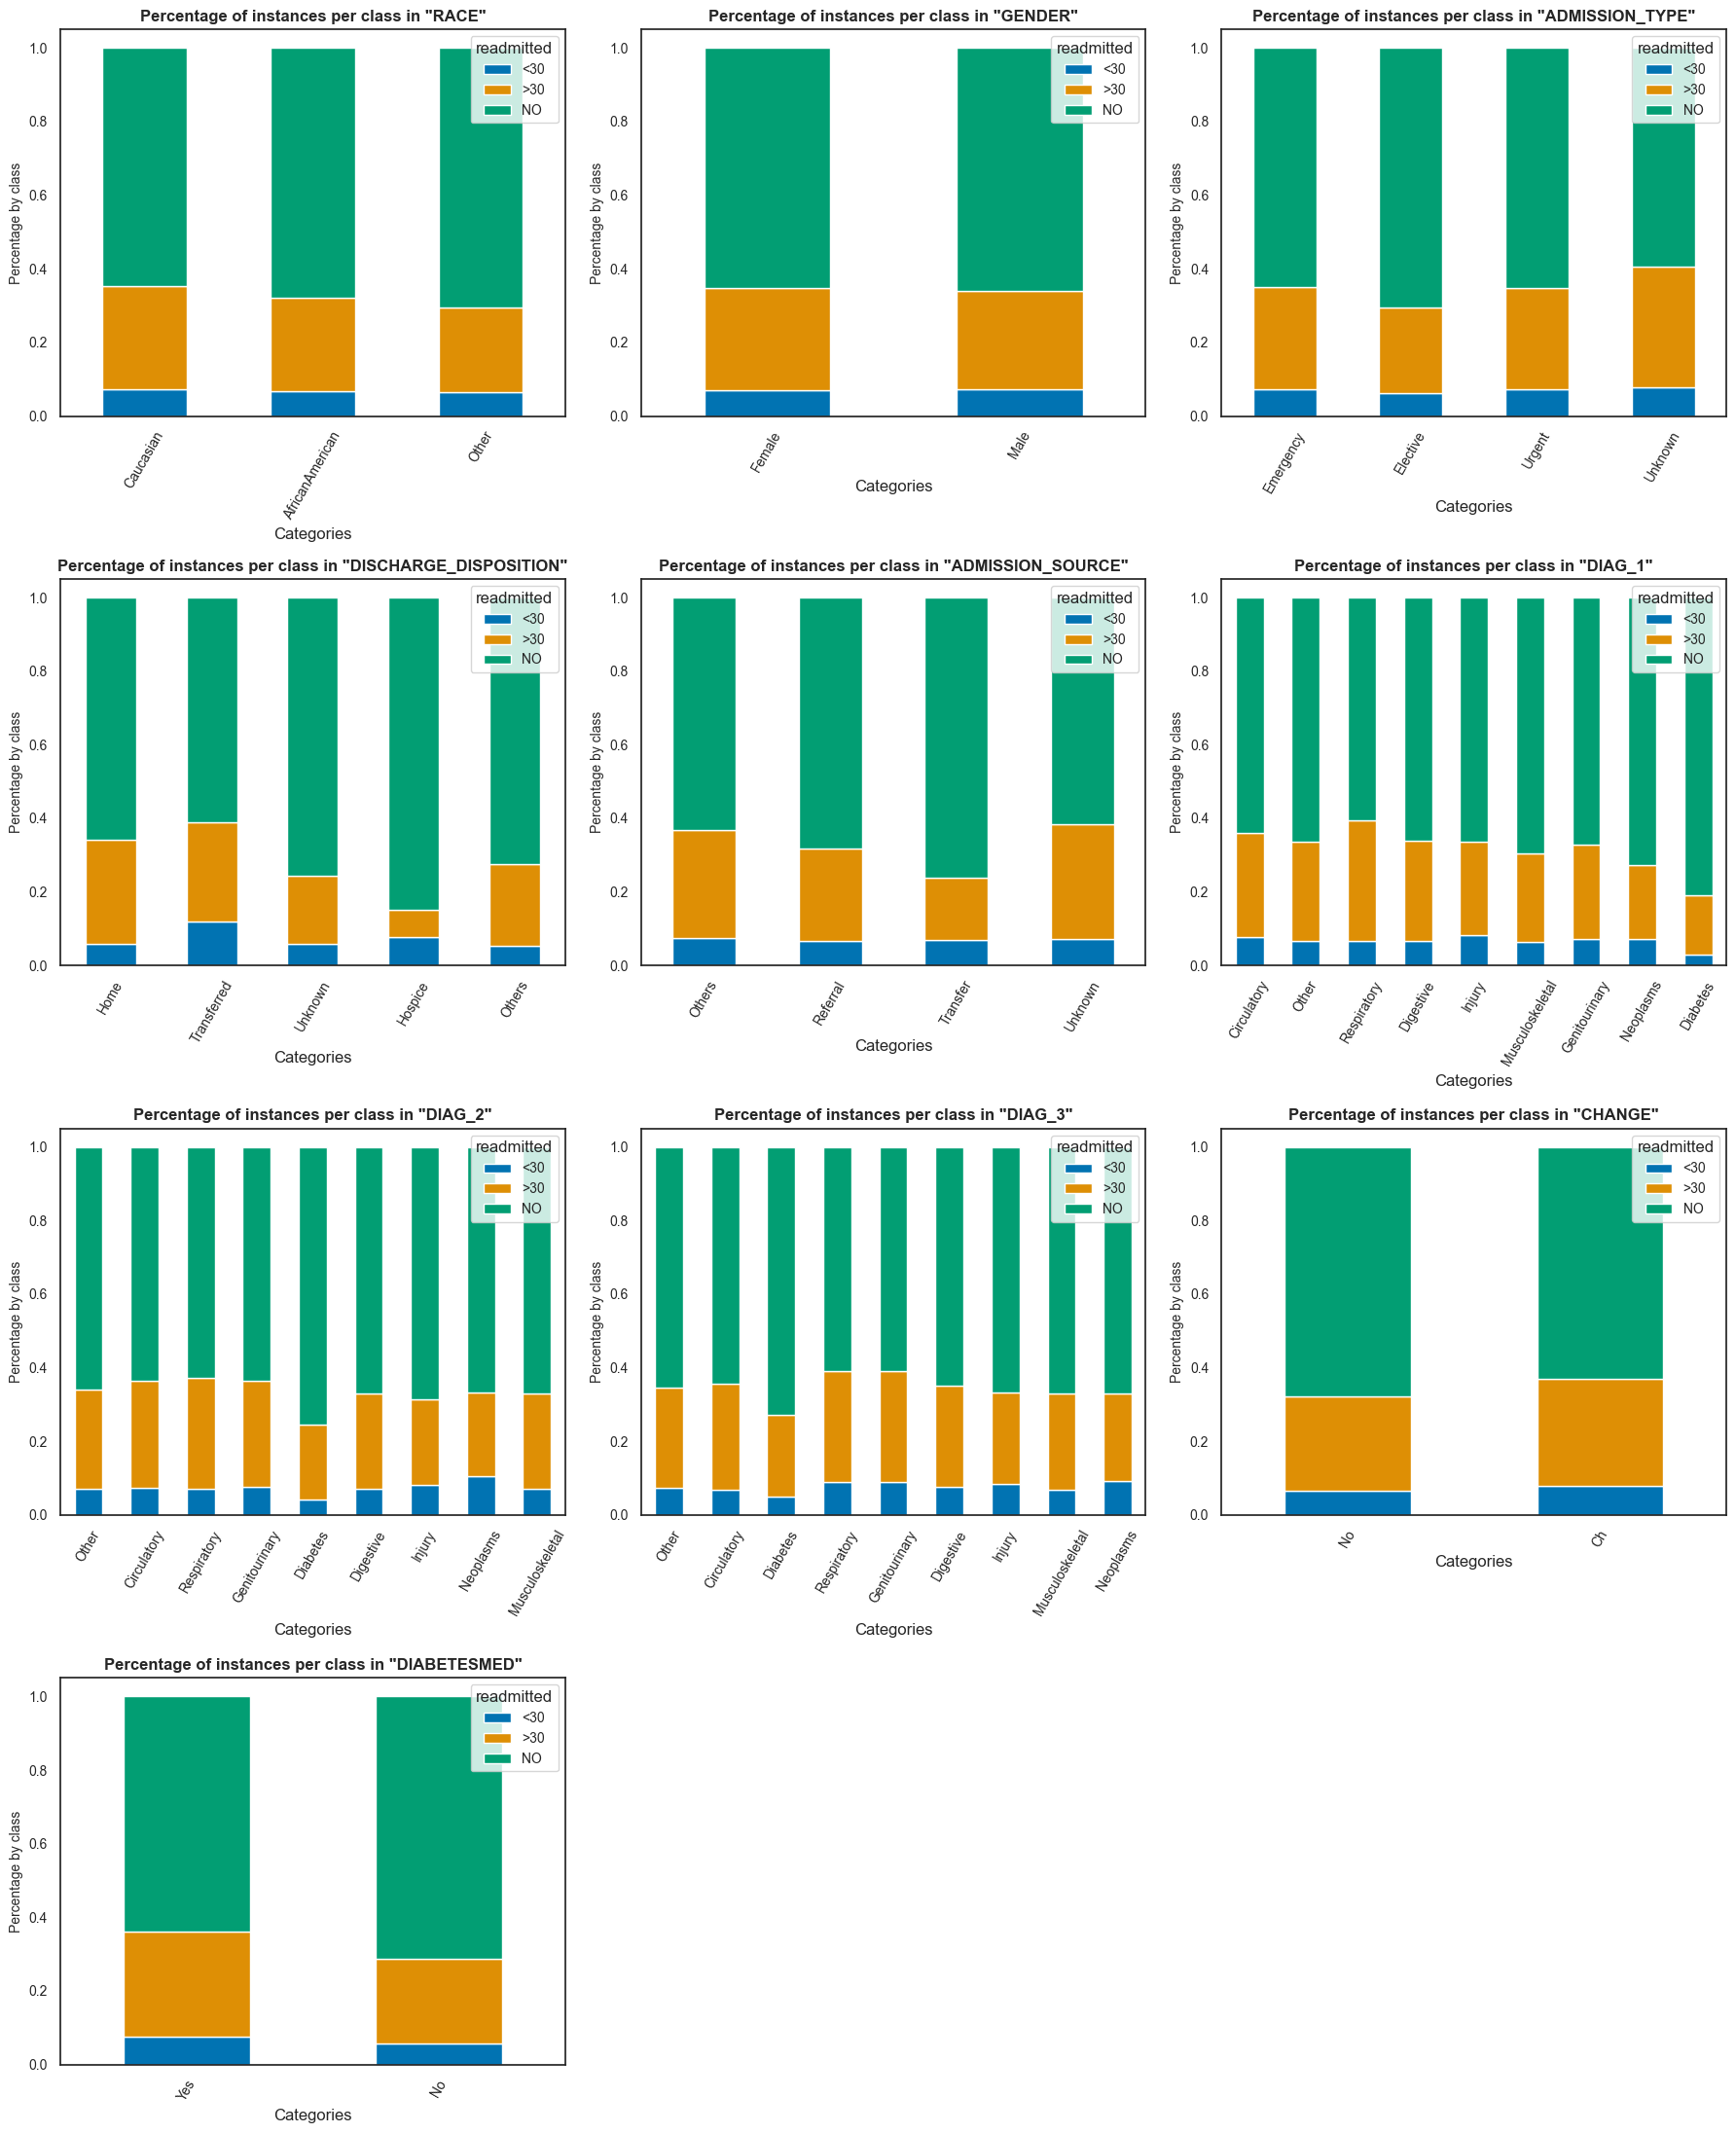

In [8]:
num_rows = math.ceil(len(feat_cat) / 3)

fig, axes = plt.subplots(num_rows, 3, figsize=(18, 6*num_rows))

# Show histogram of sensitive features by its categories
for i, feat in enumerate(feat_cat):
    row = i // 3
    column = i % 3
    ax = axes[row, column]

    sensitive_counts = features_df[feat].value_counts()
    unique_categories = sensitive_counts.index
    n_values = sensitive_counts.values

    # Count the number of instances per class for each category
    count_cat = {}
    for category in unique_categories:
        tags_cat = np.array(tags_df[features_df[feat] == category].squeeze())
        if tags_cat.size > 0:
            total_instances = tags_cat.size
            for classes in unique_classes:
                category_count = (tags_cat == classes).sum()
                count_cat[(classes, category)] = category_count / total_instances  # Normalize the count

    # Reorganize the data for DataFrame construction
    class_values = {cls: [count_cat.get((cls, category), 0) for category in unique_categories] for cls in unique_classes}
    sns.set_palette('colorblind')

    stacked_heights_df = pd.DataFrame(class_values, index=unique_categories)
    stacked_heights_df.plot(kind='bar', stacked=True, ax=ax)
    
    ax.set_xlabel('Categories', fontsize=12)
    ax.set_ylabel('Percentage by class', fontsize=10)
    ax.legend(unique_classes, title=output, loc='upper right', title_fontsize='medium', prop={'size': 10})
    ax.set_title(f'Percentage of instances per class in "{feat.upper()}"', fontsize=12, weight='bold')
    ax.tick_params(axis='x', labelrotation=60, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)

# Hide unused subplots
for i in range(len(feat_cat), num_rows * 3):
    row = i // 3
    column = i % 3
    fig.delaxes(axes[row, column])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


If you wish to use more advanced techniques, the use of FAMD allows the joint categorical and numerical variables to be projected into a lower dimensional space. Those variables whose vectors overlap represent redundancy.

Concatenating sparse arrays with multiple fill values: '[-1.6368916975323058, -1.2664130747440063, -0.6004147152903001, -0.5968966948560752, -0.9926373689936822, -1.5982492050224482, -0.7338943555356077, -0.9600362530839076, -1.5197950498755146, -1.640189929969661, -1.0814580911932408, -1.9571531358053393, -1.2251373985993925, -0.11554986583275578, -0.6796379284788563, -0.4965188049374142, -0.5836344084757366, -0.5272598566776044, -0.43837214751481607, -1.2181112765661024, -0.6947306273231906, -1.2413770418083263, -0.5870288444981939, -0.4486755455824331, -0.6118871837547741, -0.3665950600774814, -0.30336752217729696, -0.3484788956749756, -1.3110612610353949, -0.6869654594282794, -1.2225073350253841, -0.7846094797211565, -0.4161437915792761, -0.5370420460594961, -0.3285221751666699, -0.3159436451069621, -0.30192321934302957, -1.3464103682114983, -0.5626262073255102, -1.92292640408464, -0.22215730829636993, -0.16389781160399366, -1.0000953652491202, -0.47533876614818354, -1.631128104921

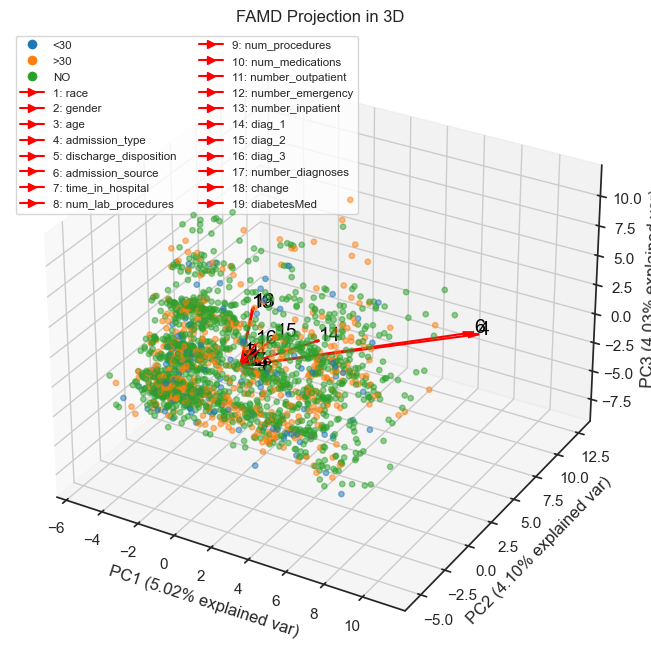

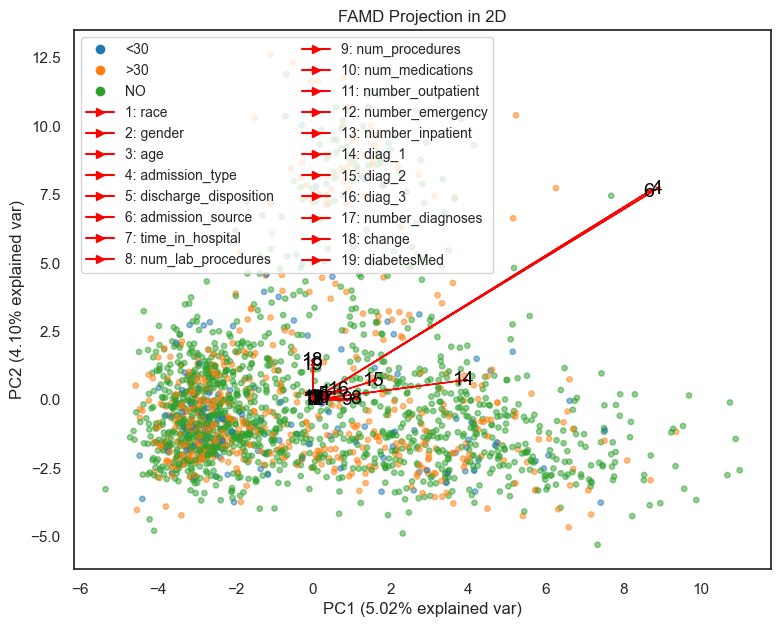

In [9]:
features_df_FAMD = features_df.copy()

# Normalize numerical variables
scaler = StandardScaler()
features_df_FAMD[feat_num] = scaler.fit_transform(features_df_FAMD[feat_num])

famd = prince.FAMD(
    n_components=3,         
    n_iter=3,               
    check_input=True,       
    random_state=42,        
    engine="sklearn",       # Use sklearn implementation for speed
    handle_unknown="error"  # How to handle unknown categorical levels
)

features_df_FAMD_transformed = famd.fit_transform(features_df_FAMD)

# Join tags_df with features_df_FAMD_transformed to align labels
transformed_with_tags = pd.concat([pd.DataFrame(features_df_FAMD_transformed), tags_df], axis=1)

# Projection of a sample of points for visualization clarity
subsample = transformed_with_tags.sample(n=2000, random_state=1)

x_component = subsample[0]
y_component = subsample[1]
z_component = subsample[2]
eigenvalues_summary_df = pd.DataFrame(famd.eigenvalues_summary)

# Define colors for each class
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'purple', 'brown', 'pink', 'gray']
color_dict = {cls: colors[i % len(colors)] for i, cls in enumerate(unique_classes)}  # Wrap around colors if more classes

# Plotting 3D scatter plot
fig1 = plt.figure(figsize=(8, 10))
ax1 = fig1.add_subplot(111, projection='3d')  # 3D plot

scatter1 = ax1.scatter(x_component, y_component, z_component, c=subsample.iloc[:, 3].map(color_dict), marker='o', s=15, alpha=0.5)
ax1.set_xlabel(f'PC1 ({eigenvalues_summary_df.iloc[0, 1]} explained var)')
ax1.set_ylabel(f'PC2 ({eigenvalues_summary_df.iloc[1, 1]} explained var)')
ax1.set_zlabel(f'PC3 ({eigenvalues_summary_df.iloc[2, 1]} explained var)')
ax1.set_title('FAMD Projection in 3D')

# Project feature vectors onto the 3D plot
scale_factor = 12
for i, feature in enumerate(feature_names):
    ax1.quiver(0, 0, 0,
               famd.column_coordinates_.loc[feature, 0] * scale_factor,
               famd.column_coordinates_.loc[feature, 1] * scale_factor,
               famd.column_coordinates_.loc[feature, 2] * scale_factor,
               color='red', arrow_length_ratio=0.05)
    ax1.text(famd.column_coordinates_.loc[feature, 0] * scale_factor,
             famd.column_coordinates_.loc[feature, 1] * scale_factor,
             famd.column_coordinates_.loc[feature, 2] * scale_factor,
             f'{i+1}', color='black', fontsize=14)

# Create custom legend with arrows instead of circles
legend_elements = []
for i, cls in enumerate(unique_classes):
    legend_elements.append(Line2D([0], [0], marker='o', color='w', label=f'{cls}', markerfacecolor=color_dict[cls], markersize=8))

for i, feature in enumerate(features_df_FAMD.columns):
    legend_elements.append(Line2D([0], [0], marker='>', color='red', label=f'{i+1}: {feature}', markersize=6))

# Display legend with two columns and smaller fontsize
ax1.legend(handles=legend_elements, loc='upper left', fontsize='x-small', ncol=2)
plt.show()

# Plotting 2D scatter plot
fig2 = plt.figure(figsize=(9, 7))
ax2 = fig2.add_subplot(111)  # 2D plot

scatter2 = ax2.scatter(x_component, y_component, c=subsample.iloc[:, 3].map(color_dict), marker='o', s=15, alpha=0.5)
ax2.set_xlabel(f'PC1 ({eigenvalues_summary_df.iloc[0, 1]} explained var)')
ax2.set_ylabel(f'PC2 ({eigenvalues_summary_df.iloc[1, 1]} explained var)')
ax2.set_title('FAMD Projection in 2D')

# Project feature vectors onto the 2D plot
for i, feature in enumerate(feature_names):
    ax2.arrow(0, 0,
              famd.column_coordinates_.loc[feature, 0] * scale_factor,
              famd.column_coordinates_.loc[feature, 1] * scale_factor,
              color='red', head_width=0.1, head_length=0.1)
    ax2.text(famd.column_coordinates_.loc[feature, 0] * scale_factor,
             famd.column_coordinates_.loc[feature, 1] * scale_factor,
             f'{i+1}', color='black', fontsize=14, ha='center', va='center')

ax2.legend(handles=legend_elements, loc='upper left', fontsize='small', ncol=2)
plt.show()


## 2. MODEL DEVELOPMENT <a class="anchor" id="model-development"></a>

### 2.1. Design: <a class="anchor" id="design"></a>

More complex development methodologies are also in use, including TRIPOD+AI [1]. It would be optimal to implement a unified procedure. Nevertheless, we have attempted to simplify the process by providing a concise overview of the design steps.

`Describe design steps:`
Two example models are proposed: Naive Bayes and Random Forest. Appropriate preprocessing has been incorporated. The categorical columns are coded by a dummy variable using 'OneHotEncoder'. Then the classification method is selected. In addition, the tags are encoded using 'Label Encoder'. Then the dataset is randomly divided into a test subset with 20% of the data and a training subset with the rest. In this case, no feature selection or dimensionality reduction method is proposed. Consequently, the models will be obtained from all the features except the identifying ones.

In [17]:
features_df_encoded, feature_names_encoded, feat_cat_encoded = handleData.encode(features_df)

# Encode Tags 
if not np.issubdtype(tags_df.dtype, np.number):
    encoderLabel = LabelEncoder()
    tags_df_encoded = encoderLabel.fit_transform(tags_df)
    tags_df_encoded = pd.Series(tags_df_encoded, index=tags_df.index, name=tags_df.name)

    tags_df_mapping = {label: code for code, label in enumerate(encoderLabel.classes_)} # Dictionary with the code reference for each class
    unique_classes_enc = np.unique(tags_df_encoded)
    print('Dictionary of tags: ', tags_df_mapping)
else:
    tags_df_encoded, unique_classes_enc  = tags_df, unique_classes

feat_train, feat_test, tags_train, tags_test = train_test_split(features_df_encoded, tags_df_encoded, test_size=0.2, random_state = 1)


### 2.2. Training and Evaluation: <a class="anchor" id="training-evaluation"></a>


#### RANDOM FOREST MODEL:
Random Forest model from scikit-learn. As defined by the library, the model is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. In particular, this model is formed by 100 trees. 

In [18]:
model_RandomForest = RandomForestClassifier(n_estimators=100, random_state=1)

model_RandomForest.fit(feat_train, tags_train) 
tags_pred = model_RandomForest.predict(feat_test)
report = classification_report(tags_test, tags_pred, zero_division=1)

print("Classification Report:\n",report)

Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96      5791
           1       1.00      0.00      0.00       447

    accuracy                           0.93      6238
   macro avg       0.96      0.50      0.48      6238
weighted avg       0.93      0.93      0.89      6238



Particular graphics such as plot-tree are beneficial for transparency in black box models such as the one in the study.

#### NAIVE BAYES MODEL:

The scikit-learn library doesn't implement models from scratch that are suitable for different types of data or distributions. However, it is possible to build a mixed model. Some foundations offer more complex models, for example: https://github.com/remykarem/mixed-naive-bayes/blob/master/mixed_naive_bayes/mixed_naive_bayes.py. 

Nevertheless, we provide a simplified version of a mixed model consisting of a Gaussian and a Categorical that fills this gap:

In [19]:
model_MixedNB = NaiveBayesMixed(feat_num, feat_cat_encoded)

model_MixedNB.fit(feat_train, tags_train)
tags_pred = model_MixedNB.predict(feat_test)

print("Classification Report:\n", classification_report(tags_test, tags_pred, zero_division=1))

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      5791
           1       0.20      0.04      0.07       447

    accuracy                           0.92      6238
   macro avg       0.57      0.52      0.52      6238
weighted avg       0.88      0.92      0.89      6238



#### LOGISTIC REGRESSION:

In [20]:
if n_classes == 2:
    model_LogisticRegression = LogisticRegression(max_iter=1000)
    model_LogisticRegression.fit(feat_train, tags_train)
    tags_pred = model_LogisticRegression.predict(feat_test)
    
    print("Classification Report:\n", classification_report(tags_test, tags_pred, zero_division=1))

Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96      5791
           1       1.00      0.00      0.00       447

    accuracy                           0.93      6238
   macro avg       0.96      0.50      0.48      6238
weighted avg       0.93      0.93      0.89      6238



Once the model has been realised, it is possible to improve its explicability by using graphs that simplify its understandabilty (`Explainability plots`). It is important to distinguish between explicability and interpretability. While the former one refers to the explenation of the decision model, the latter focuses on understanding how it works. Consequently, the interpretability requires a deeper level of detail and will support the communication with experts, while the explicability is more superficial and suitable for end users [2].

It is effective to perform an evaluation based on the graph of ROC curves. This graph relates sensitivity and specificity such that the higher the area, the better the prediction. 

In [8]:
classifiers = {'RF': model_RandomForest, 'NB': model_MixedNB}

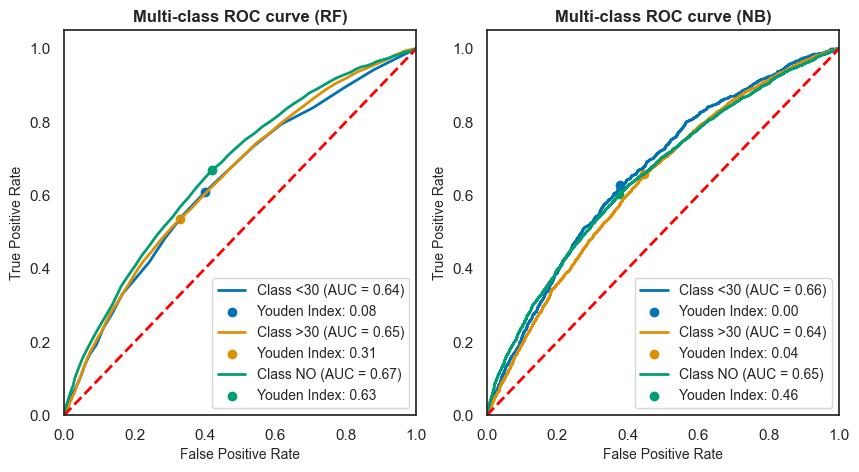

In [15]:
fig, axs = plt.subplots(1, len(classifiers), figsize=(10, 5))

for i, (classifier_name, classifier) in enumerate(classifiers.items()):
    classifier.fit(feat_train, tags_train)
    
    y_scores = classifier.predict_proba(feat_test)
    
    if n_classes > 2:
        
        # Binarize tags one-vs-all
        tags_test_binarized = label_binarize(tags_test, classes=unique_classes_enc)
        n_classes = len(unique_classes)

        # Calculate the ROC curve for each class
        for c in range(n_classes):
            fpr, tpr, thresholds = roc_curve(tags_test_binarized[:, c], y_scores[:, c])
            roc_auc = auc(fpr, tpr)
            axs[i].plot(fpr, tpr, lw=2, label=f'Class {unique_classes[c]} (AUC = {roc_auc:.2f})')
            axs[i].set_title(f'Multi-class ROC curve ({classifier_name})', fontdict={'fontsize': 12, 'weight': 'bold'})

            # Calculate Youden index
            youden_index = thresholds[np.argmax(tpr - fpr)]
            axs[i].scatter(fpr[np.argmax(tpr - fpr)], tpr[np.argmax(tpr - fpr)], marker='o', label=f'Youden Index: {youden_index:.2f}')
            
    else:
        fpr, tpr, thresholds = roc_curve(tags_test, y_scores[:, 1])
        roc_auc = auc(fpr, tpr)
        axs[i].plot(fpr, tpr, lw=2, color='tab:blue', label=f'{output} (AUC = {roc_auc:.2f})')
        axs[i].set_title(f'ROC curve ({classifier_name})', fontdict={'fontsize': 12, 'weight': 'bold'})
        
        # Calculate Youden index
        youden_index = thresholds[np.argmax(tpr - fpr)]
        axs[i].scatter(fpr[np.argmax(tpr - fpr)], tpr[np.argmax(tpr - fpr)], marker='s', color='tab:blue', label=f'Youden Index: {youden_index:.2f}')
    
    axs[i].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    axs[i].set_xlim([0.0, 1.0])
    axs[i].set_ylim([0.0, 1.05])
    axs[i].set_xlabel('False Positive Rate', fontdict={'fontsize': 10})
    axs[i].set_ylabel('True Positive Rate', fontdict={'fontsize': 10})
    axs[i].legend(loc="lower right", prop={'size': 10})
    sns.set_palette('colorblind')


plt.show()


To compare the behaviour of the two models, it is useful to plot the ROC curve of each model for ONE vs. ALL.

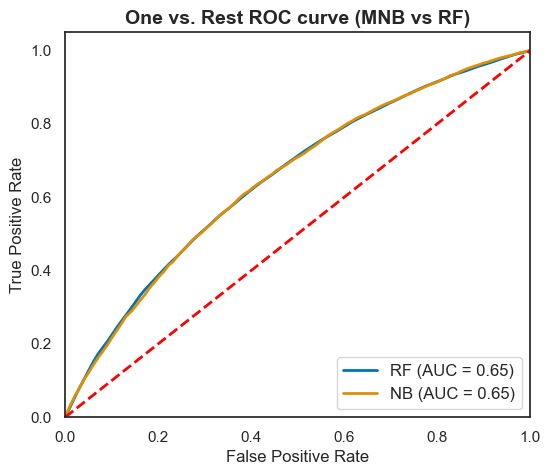

In [16]:
if n_classes > 2:
    plt.figure(figsize=(6, 5))
    for classifier_name, classifier in classifiers.items():
        tpr_list = []
        mean_fpr = np.linspace(0, 1, 100)  # Common set of points
        
        y_scores = classifier.predict_proba(feat_test)
        
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(tags_test_binarized[:, i], y_scores[:, i])
            
            # Interpolate the ROC curve to have a common set of points
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0  # Set the first point to (0, 0)
            tpr_list.append(interp_tpr)
        
        # Calculate the average ROC curve
        mean_tpr = np.mean(tpr_list, axis=0)
        roc_auc_mean = auc(mean_fpr, mean_tpr)
        
        # Plot ROC curve
        plt.plot(mean_fpr, mean_tpr, lw=2, label=f'{classifier_name} (AUC = {roc_auc_mean:.2f})')
        
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontdict={'fontsize': 12})
    plt.ylabel('True Positive Rate', fontdict={'fontsize': 12})
    plt.title('One vs. Rest ROC curve (MNB vs RF)', fontdict={'fontsize': 14, 'weight': 'bold'})
    plt.legend(loc="lower right", prop={'size': 12})
    sns.set_palette('colorblind')

    plt.show()


We also provide a confusion matrix for both models. This graph compares the predicted classes with the real ones. Ideally, we look for an identity matrix with a main diagonal of probability 1. In addition to making the tools as suitable as possible for the maximum number of groups, we use a 'cividis' colour palette ranging from soft yellow tones to a more intense blue suitable for daltonics.

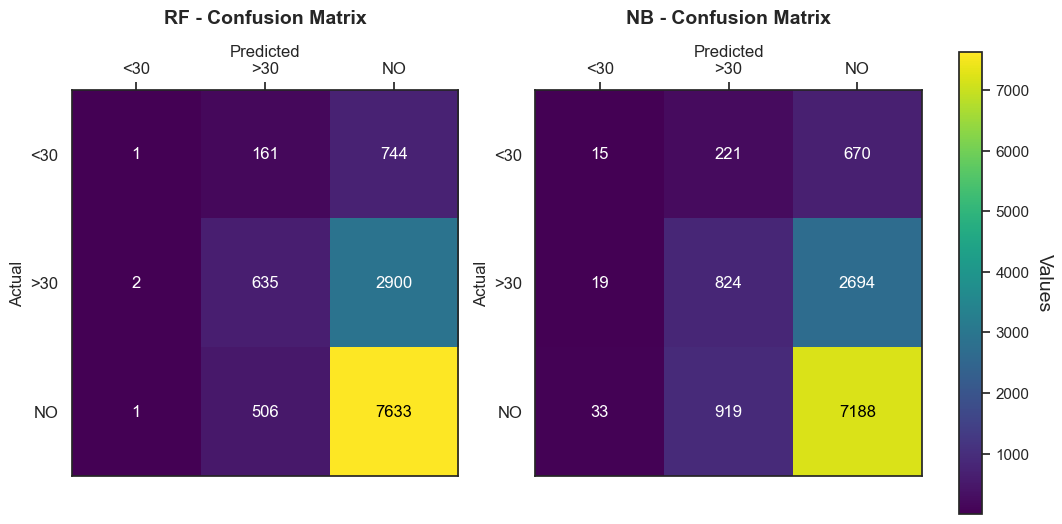

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

plt.rcParams['figure.constrained_layout.use'] = True

vmin = np.inf
vmax = -np.inf
ims = []

for i, (classifier_name, classifier) in enumerate(classifiers.items()):

    tags_pred = classifier.predict(feat_test)
    conf_matrix = confusion_matrix(tags_test, tags_pred, labels=unique_classes_enc)

    vmin = min(vmin, conf_matrix.min())
    vmax = max(vmax, conf_matrix.max())

    im = axs[i].imshow(conf_matrix, cmap='viridis')
    ims.append(im)
    
    threshold = np.max(conf_matrix) / 2

    # Loop over data dimensions to adapt text annotations
    for j in range(len(unique_classes)):
        for k in range(len(unique_classes)):
            color = "black" if round(conf_matrix[j, k], 2) > threshold else "white"
            axs[i].text(k, j, round(conf_matrix[j, k], 2), ha="center", va="center", color=color)

    axs[i].set_xticks(np.arange(len(unique_classes)))
    axs[i].set_yticks(np.arange(len(unique_classes)))
    axs[i].set_xticklabels(unique_classes, fontdict={'fontsize': 12})
    axs[i].set_yticklabels(unique_classes, fontdict={'fontsize': 12})
    axs[i].set_title(f"{classifier_name} - Confusion Matrix", fontdict={'fontsize': 14, 'weight': 'bold'}, y=1.15)
    plt.setp(axs[i].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    axs[i].set_ylabel("Actual", fontdict={'fontsize': 12})
    axs[i].set_xlabel("Predicted", fontdict={'fontsize': 12})

# Update all imshow objects with the same vmin and vmax
for im in ims:
    im.set_clim(vmin, vmax)

# Add a single colorbar for all subplots
cbar = fig.colorbar(ims[0], ax=axs, fraction=0.046, pad=0.04)
cbar.set_label('Values', rotation=-90, va="bottom", fontsize=14)

# Invert X axis labels
for ax in axs:
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')

plt.show()


It might be useful to use graphs that show the importance of features in making predictions, such as the graph of functions associated with the models (feature importances, coefficients...) or another more complex one such as SHAP (SHapley Additive exPlanations) [1].

Feature importance is very useful for detecting useless variables. An interesting approach could be to delete the features below a threshold and look at the performance evolution.

The figure layout has changed to tight


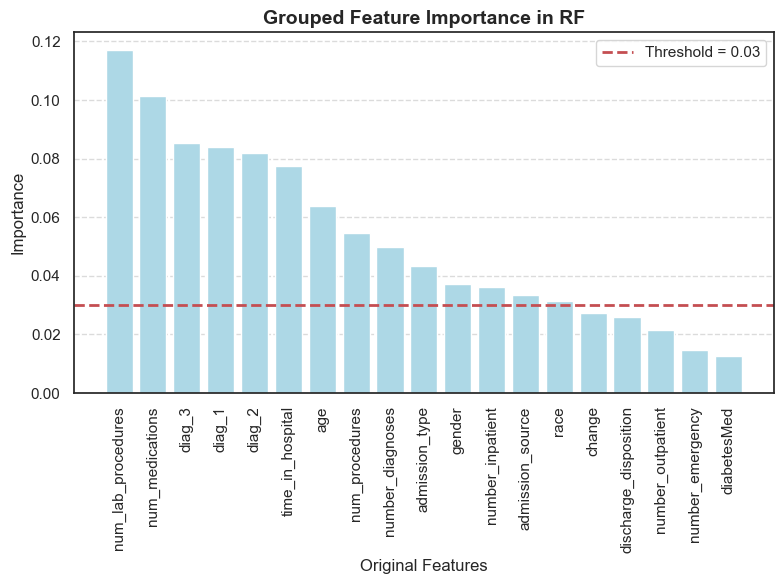


For Mixed Naive Bayes, try other methods such as Shapley


In [18]:
feature_threshold = 0.03  # Define your feature threshold here

for classifier_name, classifier in classifiers.items():
    if classifier_name == 'NB':
        print("\nFor Mixed Naive Bayes, try other methods such as Shapley")

    elif classifier_name == 'RF':
        feature_importance = classifier.feature_importances_
        sorted_grouped_features = handleData.group_feature_importanceT(feature_names_encoded, feature_importance, feat_cat_encoded)
        sorted_features, importances = zip(*sorted_grouped_features)

        plt.figure(figsize=(8, 6))
        plt.bar(range(len(importances)), importances, align='center', color='lightblue')
        plt.xticks(range(len(importances)), sorted_features, rotation=90)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.xlabel('Original Features', fontdict={'fontsize':12})
        plt.ylabel('Importance', fontdict={'fontsize':12})
        plt.title(f'Grouped Feature Importance in {classifier_name}', fontdict={'fontsize':14, 'weight': 'bold'})

        # Add a horizontal line at feature_threshold
        plt.axhline(y=feature_threshold, color='r', linestyle='--', linewidth=2, label=f'Threshold = {feature_threshold}')
        
        plt.legend()
        plt.tight_layout()
        plt.show()

In [19]:
if n_classes == 2:
    coefficients = model_LogisticRegression.coef_[0]
    feature_coef = list(zip(feature_names_encoded, coefficients))
    feature_coef_sorted = sorted(feature_coef, key=lambda x: abs(x[1]), reverse=True) # Sort the list

    sorted_features = [x[0] for x in feature_coef_sorted]
    sorted_coefficients = [x[1] for x in feature_coef_sorted]

    number_features = min(20, len(sorted_features)) # Number of feature coefficients to display

    plt.figure(figsize=(6, number_features/4))
    plt.barh(sorted_features[:number_features], sorted_coefficients[:number_features], color='lightblue', height=0.8)
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    plt.xlabel('Coefficients')
    plt.ylabel('Features')
    plt.title('Coefficients of Logistic Regression', fontdict={'fontsize': 14, 'weight': 'bold'})
    plt.show()


## 3. DEPLOYMENT and USE <a class="anchor" id="deployment-use"></a>

Apart from model development, analyse how the model deals with unexpected problems. We offer different Shapley plots (`Explainability plots after training`).

In [21]:
file_name = 'dataset_test_QC.csv'
data_test = pd.read_csv(path + file_name)

feat_test = data_test.drop(output,axis=1)
feat_test, _, _ = handleData.encode(feat_test)
feat_test = handleData.adjust_categories(feat_test, feature_names_encoded)

# ### Uncomment only if you want to binarise a multi-class classification problem ###
# if positive_class:
#     dataset[output] = pd.Series(np.where(dataset[output] == positive_class, 1, 0), index=dataset[output].index, name=output)

# Encode Tags 
if not np.issubdtype(tags_test.dtype, np.number):
    tags_test_encoded = encoderLabel.transform(tags_test)
    tags_test = pd.Series(tags_test_encoded, index=tags_test.index, name=tags_test.name)

feat_train = features_df_encoded
tags_train = tags_df

for classifier_name, classifier in classifiers.items():    
    classifier.fit(feat_train, tags_train)

In [12]:
if n_classes > 2:
    
    # Calculate SHAP values
    explainer = shap.TreeExplainer(classifiers['RF'], feat_test[:20])
    shap_values = explainer.shap_values(feat_test[:20])
    
    # Calculate average importance of feature by class
    shap_sums = np.abs(shap_values).mean(axis=1)
    
    fig = go.Figure()
    
    # Add a bar for each class
    for i in range(len(shap_values)):
        fig.add_trace(go.Bar(y=shap_sums[i], x=feature_names, name=f'{unique_classes[i]}'))
    
    # Update plot design
    fig.update_layout(
        barmode='stack',
        title="Random Forest - SHAP Contribution by Features",
        title_x=0.5,
        xaxis_title="Features",
        yaxis_title="Average SHAP Value",
        xaxis_tickangle=-65
    )
    fig.update_layout(
        barmode='stack',
        title={
            'text': "Random Forest - SHAP Contribution by Features",
            'x': 0.5,
            'font': {'size': 22}
        },
        xaxis={
            'title': {'text': "Features", 'font': {'size': 16}},
            'tickangle': -65,
            'tickfont': {'size': 16}
        },
        yaxis={
            'title': {'text': "Average SHAP Value", 'font': {'size': 20}},
            'tickfont': {'size': 16},
        },
        legend= {'font': {'size': 18}}
    )
    sns.set_palette('colorblind')

    fig.show()

100%|===================| 14029/14044 [02:58<00:00]        

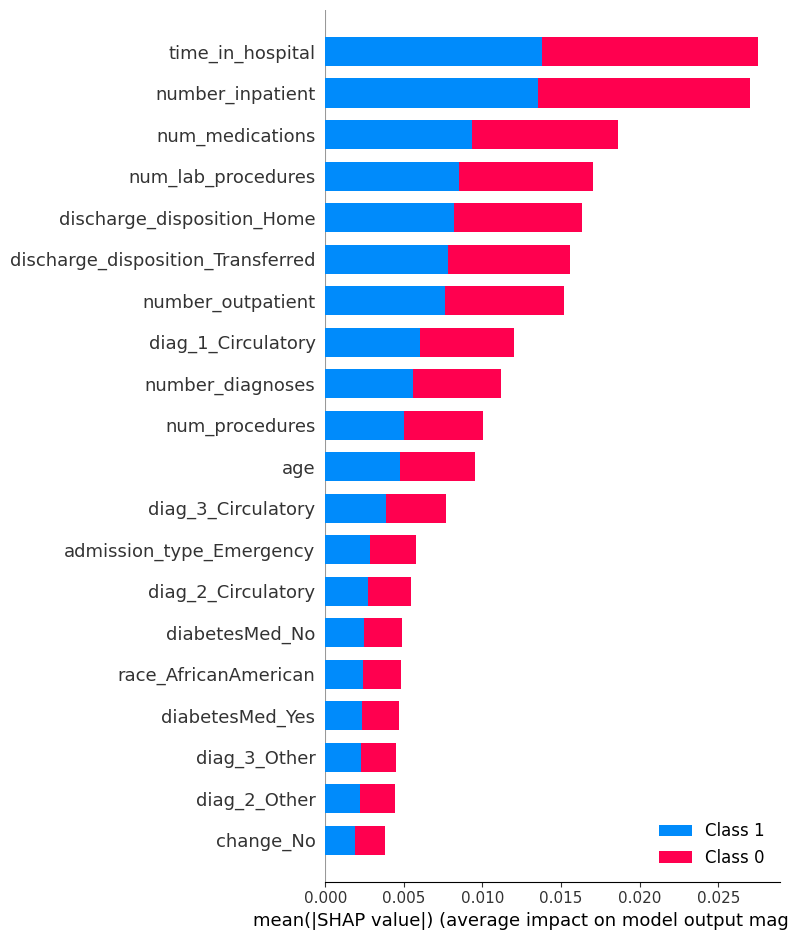

In [22]:
if n_classes == 2:
    # Calculate SHAP values
    explainer = shap.TreeExplainer(classifiers['RF'], feat_test[:20])
    shap_values = explainer.shap_values(feat_test)

    # Calculate average importance of feature by class
    shap_sums = np.abs(shap_values).mean(axis=1)
    
    fig = go.Figure()
    sns.set_palette('colorblind')
    shap.summary_plot(shap_values, feat_test, feature_names=feature_names_encoded, plot_type="bar")

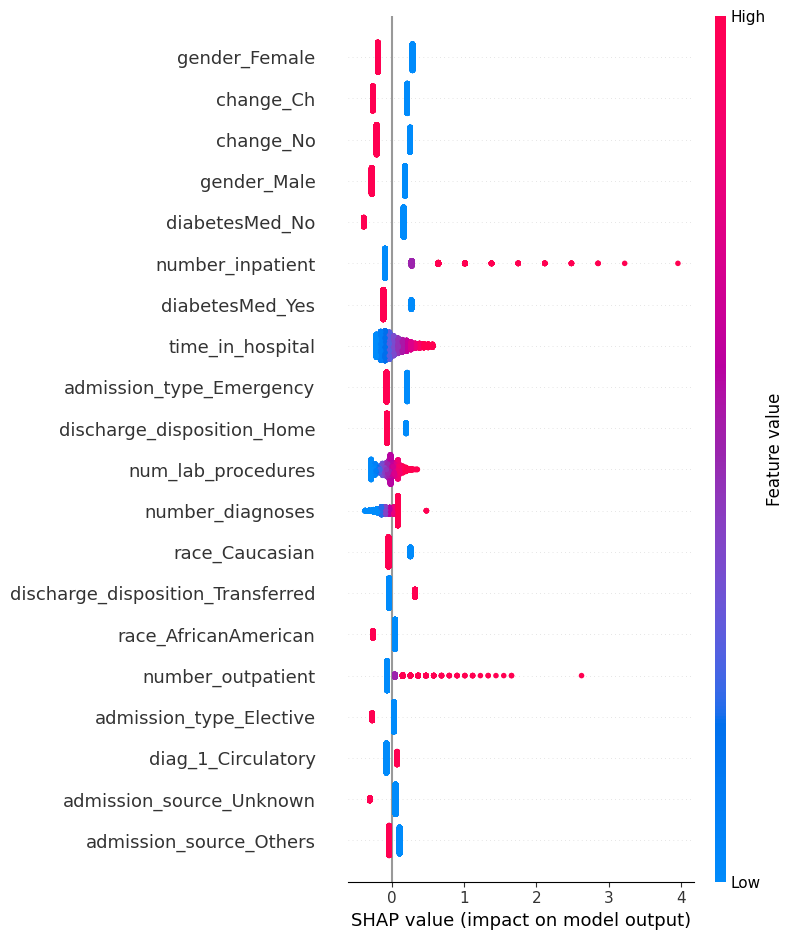

<Figure size 640x480 with 0 Axes>

In [23]:
if n_classes == 2:

    # Calculate shap values
    explainer = shap.Explainer(model_LogisticRegression, feat_test[:20])
    shap_values = explainer.shap_values(feat_test)

    fig = go.Figure()

    try:
        # Plot a SHAP Summary Chart
        shap.summary_plot(shap_values, feat_test, feature_names=feature_names_encoded)
        sns.set_palette('colorblind')
        plt.tight_layout()
        
    except RuntimeError as e:
        if "Colorbar layout of new layout engine not compatible" in str(e):
            pass  # Ignore the error related to the colorbar layout
        else:
            raise e  


## 4. MANAGEMENT <a class="anchor" id="management"></a>

### 4.1. Documentation: <a class="anchor" id="documentation"></a>

In addition, a continuous documentation of the results (`Output ocumentation`) should be carried out to allow trazability and increase transparency, so that it is possible to identify the reasons why a decision was wrong. At the same time, it is necessary to establish a communication with the end users , so that they are fully aware of the features, limitations and shortcomings of the AI.

Considering a "Recordings" folder to store the registers, there is an example of how to register the metrics of the Random Forest model metrics.

In [25]:
# Extract metrics from RF classification report 
report_lines = report.split('\n')
metrics = report_lines[-2].split()

precision = float(metrics[2])
recall = float(metrics[3])
f1 = float(metrics[4])
support = int(metrics[5])
date = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

data_recording = pd.DataFrame({
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1],
    'Support': [support],
    'Model Version': 'Version 1.0',
    'Date': [date]
})

file_hour = datetime.now().strftime('%Y%m%d_%H%M%S')
file_name = f'recordings/recording_{file_hour}.csv'
data_recording.to_csv(file_name, index=False)

# Print data as a table
print("Extracted metrics:")
print(data_recording.to_string(index=False))
print(f"\nData registered in {file_name} at {data_recording['Date'].iloc[0]}")

Extracted metrics:
 Precision  Recall  F1 Score  Support Model Version                Date
      0.93    0.93      0.89     6238   Version 1.0 2024-07-02 11:38:19

Data registered in recordings/recording_20240702_113819.csv at 2024-07-02 11:38:19


#### Change Log

| Date (YYYY-MM-DD) | Version | Changed By          | Change Description                          |
| ----------------- | ------- | ------------------- | ------------------------------------------- |
| 2024-06-05        | 1.0     | Carlos de Manuel    | Development of the initial version          |


### 4.3. Cooperation and Incident sharing: <a class="anchor" id="cooperation-and-sharing"></a>

In addition, it might be positive to propose a template to reporting incidents (`Incident sharing`). This could include data such as user's information, details of the incident (date, time and location), and a brief description of the incident or the possible impact.

To inform about the model, a 'disclaimer' template like the following one could be used (`Disclaimer communication`):

**DISCLAIMER FOR TRUSTWORTHY AI MODEL [Model Name]**

*This trustworthy AI model, [Model Name], has been meticulously developed for [intended use cases]. It underwent extensive training on [describe the data] and consistently demonstrates a high level of accuracy, with performance metrics indicating [mention performance metrics] when assessed in [describe the context or domain]. The model has undergone rigorous testing for fairness and robustness, although it's important to acknowledge [include any limitations regarding fairness, bias, and robustness].*

*[Model Name] employs inherently [transparent/ not transparent] algorithms to the end-user, and we employ [describe any interpretability tools or methods used] to ensure transparency and interpretability. Data privacy and security are paramount, and we uphold strict measures [describe mesures] to safeguard user data in compliance with regulations.*

*While [Model Name] has been carefully designed to minimize biases and ethical concerns, users are urged not to rely solely on it for [critical decisions/ any sensitive use cases]. It is imperative to exercise caution when interpreting the model's predictions and, when appropriate, consult with a qualified human expert for review.*

*To maintain your trust in [Model Name], we are dedicated to routine updates and maintenance, ensuring it remains aligned with the latest data and best practices. Should you have any inquiries, concerns, or encounter any issues, please do not hesitate to reach out to us at [contact information].*

*Please take note that [Company/Developer Name] cannot be held liable for any harm or damage resulting from the use of [Model Name] outside of its designated use cases and recommendations.*

*[Include any additional specific disclaimers related to the model].*

## REFERENCES  <a class="anchor" id="references"></a>

1. Collins, Gary S., et al. ‘TRIPOD+AI Statement: Updated Guidance for Reporting Clinical Prediction Models That Use Regression or Machine Learning Methods’. BMJ, vol. 385, Apr. 2024, p. e078378. www.bmj.com, https://doi.org/10.1136/bmj-2023-078378.
 <br>
2. Molnar, C. (s. f.). Aprendizaje automático interpretable. https://fedefliguer.github.io/AAI/. Accesed 7 May 2024 <br>

&copy; 2024 Carlos de Manuel & Carlos Sáez - Universitat Politècnica de València 2024
